In [1]:
import pandas as pd
import numpy as np
import math as mth
from scipy import stats as st
from datetime import datetime
from statsmodels.stats.proportion import proportions_ztest
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
plt.style.use('ggplot')

import warnings

warnings.filterwarnings("ignore")

## Шаг 1. Предобработка данных

In [ ]:
final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
display(final_ab_events.head(5), final_ab_events.info(), final_ab_events.describe())

In [ ]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

Меняем тип данных в колонке с датой

In [ ]:
final_ab_events['event_name'].unique()

In [ ]:
final_ab_events.isnull().sum()

Пропуски в details оставляем, тк не все пользователи совершили покупку

In [ ]:
final_ab_events.duplicated().sum()

In [ ]:
ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv') 
display(ab_project_marketing_events.head(5), ab_project_marketing_events.info())

In [ ]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

Меняем тип данных в колонках с датой

In [ ]:
print(ab_project_marketing_events.isnull().sum())
print()
print(ab_project_marketing_events.duplicated().sum())

In [ ]:
final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
display(final_ab_new_users.head(5), final_ab_new_users.info())

In [ ]:
print(final_ab_new_users.isnull().sum())
print()
print(final_ab_new_users.duplicated().sum())

final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

Меняем тип данных в колонках с датой

In [ ]:
final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
display(final_ab_participants.head(5), final_ab_participants.info())

In [ ]:
print(final_ab_participants.isnull().sum())
print()
print(final_ab_participants.duplicated().sum())

## Шаг 2. Оценка корректности проведения теста:

### Соответствие данных требованиям технического задания. Проверка корректности всех пунктов технического задания.


In [ ]:
#Выбираем всех пользователей из теста
final_ab = final_ab_participants.query('ab_test == "recommender_system_test"')
print(final_ab['user_id'].nunique())

In [ ]:
#объединяем с пользователями, зарегистрировавшимися с 7 по 21 декабря 2020 года.
final_ab = final_ab.merge(final_ab_new_users, on = 'user_id', how = 'inner')
display(final_ab['user_id'].nunique())

In [ ]:
display(final_ab['first_date'].min(), final_ab['first_date'].max())

In [ ]:
print(ab_project_marketing_events.query("start_dt > '2020-12-01'"))

In [ ]:
print(final_ab.groupby('group').agg({'user_id':'count'}))
print(final_ab.groupby('group').agg({'user_id':'nunique'}))

In [ ]:
a_group = final_ab_participants.query('ab_test == "recommender_system_test" and group == "A"')[['user_id']]
print(a_group.nunique())
b_group = final_ab_participants.query('ab_test == "recommender_system_test" and group == "B"')[['user_id']]
print(b_group.nunique())

groups = pd.concat([a_group, b_group]) #полностью объединим таблицы и посчитаем дубликаты

print(groups.duplicated().sum(), 'пользователей участвует в двух группах')

In [ ]:
groups_other = final_ab_participants.query('ab_test != "recommender_system_test"')[['user_id']]
groups_both = pd.concat([groups, groups_other])
print(groups_both.duplicated().sum(), 'пользователей участвует в двух тестах')

In [ ]:
#удалим пользователей, попавших в 2 теста
users_after_fil = final_ab_participants['user_id']
print(users_after_fil.duplicated().sum())

users_after_fil = users_after_fil.drop_duplicates(keep=False)
print(users_after_fil.nunique())

In [ ]:
final_ab_afetr_fil = final_ab.merge(users_after_fil, on = 'user_id', how = 'inner')
print(final_ab_afetr_fil['user_id'].nunique(), 'пользователей было заявлено')

In [ ]:
final_ab_afetr_fil = final_ab_afetr_fil.merge(final_ab_events,  on = 'user_id', how = 'inner')
final_ab_afetr_fil['event_dt'] = final_ab_afetr_fil['event_dt'].dt.round('D')
display(final_ab_afetr_fil.head(5))
display(final_ab_afetr_fil['event_dt'].min(), final_ab_afetr_fil['event_dt'].max())

In [ ]:
print(final_ab_afetr_fil['user_id'].nunique(), 'пользователей совершили действие')

In [ ]:
#присваиваем ранг действиям, чтобы избежать ошибки, если действия были совершены с разницей меньше секунды
def find_rating(act):
    if act == 'product_page': 
        return 2
    if act == 'product_cart': 
        return 3
    if act == 'purchase': 
        return 4
    else: 
        return 1
final_ab_afetr_fil['rank'] = final_ab_afetr_fil['event_name'].apply(find_rating) 
display(final_ab_afetr_fil.head(5))

In [ ]:
#посчитаем именно действия, которые были совершены за 14 дней с момента регистрации пользователями

final_ab_afetr_fil['deadline'] = 0
for index, row in final_ab_afetr_fil.iterrows():
    final_ab_afetr_fil['deadline'][index] =  (row[3] + pd.Timedelta(days=14))
        
final_ab_afetr_fil = final_ab_afetr_fil.query('event_dt <= deadline')        
display(final_ab_afetr_fil.head(5))

In [ ]:
perc = final_ab_afetr_fil.groupby('region').agg({'user_id':'nunique'}).reset_index()
perc['perc'] = round(((perc['user_id']/perc['user_id'].sum()) * 100), 2)
display(perc)

H0 - для пользователя из региона EU вероятность попасть в тест = 15%

H1 - для пользователя из региона EU вероятность попасть в тест отличается от 15%

In [ ]:
count = final_ab_new_users.query('region == "EU"').shape[0]

nobs = final_ab.query('region == "EU"').shape[0]

alpha = .01

stat, pval = proportions_ztest(count, nobs, alpha)

print('p-value: {}'.format(pval))
if pval >= alpha: 
    print('Нулевая гипотеза не отвергается: для пользователя из региона EU вероятность попасть в тест составляет 15%.')
else:
    print('Нулевая гипотеза отвергается: для пользователя из региона EU вероятность попасть в тест отличается от 15%.')

In [ ]:
final_ab_con = final_ab_afetr_fil.sort_values(by=['user_id', 'event_dt', 'rank'])
act_rank = final_ab_con.groupby('user_id').agg({'event_dt': 'min', 'event_name': 'first'}).reset_index()
display(act_rank.groupby('event_name').agg({'user_id':'count'}))

In [ ]:
#удаляем эти 5 пользователей
act_rank = act_rank[act_rank['event_name'] == 'login']
final_ab_afetr_fil = final_ab_afetr_fil.merge(act_rank, on = 'user_id', how='inner')

У 5 пользователей первое действие покупка. удалили их

В тесте recommender_system_test участвовали пользователи, зарегистрированные с 07-21 декабря, но 5 пользователей были зарегистрированы раннее, на 07.12 приходится purchase

Группы А и В неравны.

Между группами А и В нет перечесений в пользователях.

Но есть пересечения пользователей между тестами

Дата остановки в ТЗ 2021-01-04, в данных 2020-12-31

Есть пересечение с др маркетинговыми активностями 'Christmas&New Year Promo  EU', 'CIS New Year Gift Lottery'

Процент новых пользователей из региона EU не 15%, а 93.04%

всего пользователей 6701, но действия совершили только 2788

2020-12-31 есть данные только по группе В

для проведения теста нужно пользователей: 
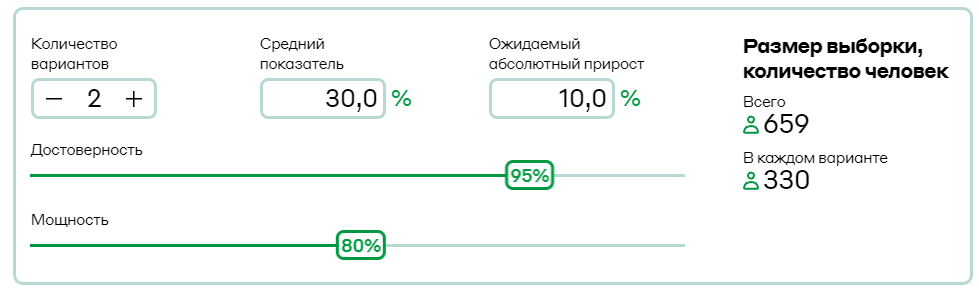





## Шаг 3. EDA:

### Количество событий на пользователя одинаково распределены в выборках?

In [ ]:
a = final_ab_afetr_fil.query('group == "A"').groupby(['user_id'], as_index=False).agg({'event_name':'count'}).sort_values(by='event_name', ascending=False)

fig = plt.figure()

hist = sns.histplot(data=a, x="event_name", bins = 25)
hist.set_title('количество событий на пользователя (А)') 
fig.set_figwidth(10)
fig.set_figheight(8);

display(a.median())

In [ ]:
b = final_ab_afetr_fil.query('group == "B"').groupby(['user_id'], as_index=False).agg({'event_name':'count'}).sort_values(by='event_name', ascending=False)

fig = plt.figure()

hist = sns.histplot(data=b, x="event_name", bins = 25)
hist.set_title('количество событий на пользователя (В)')
fig.set_figwidth(10)
fig.set_figheight(8);

display(b.median())

в группе В явно меньше активных пользователей, действий на пользователя меньше
____

### Как число событий в выборках распределено по дням?

In [ ]:
a = final_ab_afetr_fil.query('group == "A"').groupby('event_dt', as_index=False).agg({'event_name':'count'}).sort_values(by='event_dt', ascending=True)
fig = plt.figure()
a['event_dt'] = a['event_dt'].astype('str')
sns.barplot(x='event_dt', y='event_name', data=a)
hist.set_title('количество событий по деям (А)') 
plt.xticks(rotation=50)
fig.set_figwidth(10)
fig.set_figheight(8);

display(a.median())

In [ ]:
b = final_ab_afetr_fil.query('group == "B"').groupby('event_dt', as_index=False).agg({'event_name':'count'}).sort_values(by='event_dt', ascending=True)
fig = plt.figure()
b['event_dt'] = b['event_dt'].astype('str')
sns.barplot(x='event_dt', y='event_name', data=b)
hist.set_title('количество событий по деям (B)') 
plt.xticks(rotation=50)
fig.set_figwidth(10)
fig.set_figheight(8);

display(b.median())

число событий в выборках по дням распределено неравномерно. 

в группе А виден всплеск активности с 14-27 декабря.

в группе В, если сравнить относительно А, всплески не сильно выражены, но количество событий по дням не равномерно

___

### Как меняется конверсия в воронке в выборках на разных этапах?

In [ ]:
final_ab_afetr_fil.query('group == "A"')['user_id'].nunique()

In [ ]:
final_ab_a = final_ab_afetr_fil.query('group == "A"').groupby(['event_name', 'rank']).agg({'user_id':'nunique'})\
.sort_values(by='rank', ascending=True).reset_index()
display(final_ab_a)

Теперь видно, сколько уникальных пользователей дошло до каждого этапа продуктовой воронки. совершило покупку пользователей больше, чем пользователей, просмотревших корзину. Скорее всего есть возможность перейти на стр покупки, минуя корзину. Плюс была ошибка в формировании групп теста.

In [ ]:
final_ab_a['total'] = final_ab_afetr_fil.query('group == "A"')['user_id'].nunique()
final_ab_a['percentage_A'] = ((final_ab_a['user_id']/final_ab_a['total']) * 100).round(2)
display(final_ab_a)

In [ ]:
fig = go.Figure(go.Funnel(
    y = final_ab_a['event_name'],
    x = final_ab_a['user_id'],
    textinfo = "value+percent initial+percent previous"))
                
fig.show()

In [ ]:
#добавим данные по воронке в таблицу
final_ab_a['percentage_funnel_A'] = (final_ab_a['user_id']/final_ab_a['user_id'].shift(1,fill_value=0)) * 100
final_ab_a.head()

у группы А 31% доходит до покупки

In [ ]:
final_ab_b = final_ab_afetr_fil.query('group == "B"').groupby(['event_name', 'rank']).agg({'user_id':'nunique'})\
.sort_values(by='rank', ascending=True).reset_index()

final_ab_b['total'] = final_ab_afetr_fil.query('group == "B"')['user_id'].nunique()
final_ab_b['percentage_A'] = ((final_ab_b['user_id']/final_ab_b['total']) * 100).round(2)

fig = go.Figure(go.Funnel(
    y = final_ab_b['event_name'],
    x = final_ab_b['user_id'],
    textinfo = "value+percent initial+percent previous"))
                
fig.show()

#добавим данные по воронке в таблицу
final_ab_b['percentage_funnel_A'] = (final_ab_b['user_id']/final_ab_b['user_id'].shift(1,fill_value=0)) * 100
final_ab_b.head()

у группы В 28% доходит до покупки, и конверсии в просмотр карточек товаров ниже, чем у группы А.

____

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

выборки неравны, есть пользователи, попавшие в группы не с момента регистрации

в группе А больше активных пользователей

число событий в выборках по дням распределено неравномерно.


у группы А нет данных о действиях 31 декабря

In [ ]:
final_ab_con = final_ab_afetr_fil[['event_dt','group']].drop_duplicates() 
display(final_ab_con.sort_values(by='event_dt'))

## Шаг 4. Оценка результатов A/B-тестирования:

H0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

Н1 - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница

In [ ]:
def z_test(pay_A, pay_B, leads_A, leads_B, alpha):
    purchases = np.array([pay_A, pay_B])

    leads = np.array([leads_A, leads_B])

# пропорция успехов в первой и второй группе:
    p1 = purchases[0]/leads[0]
    p2 = purchases[1]/leads[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])

# разница пропорций в датасетах
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

In [ ]:
a = final_ab_afetr_fil.query('group == "A"')['user_id'].nunique() #берем всех уникальных пользователей, которые быди заявлены
b = final_ab_afetr_fil.query('group == "B"')['user_id'].nunique()

print('Сравнение группы Б с контрольной группой А')

#login
z_test(final_ab_a.loc[0, 'total'], final_ab_b.loc[0, 'total'], a, b, 0.1)

#product_page
z_test(final_ab_a.loc[1, 'total'], final_ab_b.loc[1, 'total'], a, b, 0.1)

#product_cart
z_test(final_ab_a.loc[2, 'total'], final_ab_b.loc[2, 'total'], a, b, 0.1)

#purchase
z_test(final_ab_a.loc[3, 'total'], final_ab_b.loc[3, 'total'], a, b, 0.1)

к проводится множественное сравнение, то возрастает вероятность ошибки 1 рода. чтобы избежать ее применяется метод корректировки FWER

всего сравнений = 5

Бонферрони:

alpha = 0.05/5

alpha = 0.1

А и В не сбалансированы по пользователям без событий, из-за этого значение p-value слишком большое.

___



## Вывод

рузальтаты АВ-теста считаю некорректными. 

Тестирование изменений, связанных с внедрением улучшенной рекомендательной системы проверить не получилось,  из-за: 
- несбалансированных групп, 
- пересечения тестовой аудитории с конкурирующим тестом, 
- совпадения теста и маркетинговых событий, 
- некорректных временных границ тест.